In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk import pos_tag
import nltk
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF, PCA
from sklearn.cluster import KMeans
from sklearn.manifold import Isomap, TSNE
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense, TimeDistributed, Embedding, GlobalAveragePooling1D, Flatten, SimpleRNN, GRU, Dropout, LSTM, Bidirectional
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
import os
import re
plt.style.use('default')


In [2]:
df = pd.read_csv('./db_cat.csv', index_col=0).dropna(axis=0)
df

,url,title,content,cat
0,https://stackoverflow.com/questions/2081586/we...,Web scraping with Python - Stack Overflow,Teams Q&A for work Connect and share knowledge...,0
1,https://stackoverflow.com/questions/2081586/we...,Web scraping with Python - Stack Overflow,Teams Q&A for work Connect and share knowledge...,1
2,https://stackoverflow.com/talent,Reach the world’s largest collection of tech t...,Teams Q&A for work Connect and share knowledge...,1
3,https://stackoverflow.co/,Empowering the world to develop technology thr...,\n Our asynchronous knowledge managem...,1
4,https://apple.stackexchange.com/questions/4376...,Why is Homebrew installed in /opt/homebrew on ...,Ask Different is a question and answer site fo...,1
...,...,...,...,...
3197,https://stackoverflow.com/legal/privacy-policy,Privacy Policy - Stack Overflow,Teams Q&A for work Connect and share knowledge...,0
3198,https://stackoverflow.com/users/signup?ssrc=si...,Sign Up - Stack Overflow,Teams Q&A for work Connect and share knowledge...,0
3199,https://optout.networkadvertising.org/?c=1,{{ $root.title }},Try Again - Learn More,1
3200,https://support.google.com/google-ads/answer/2...,About similar segments on the Display Network ...,Similar segments is a targeting feature that u...,0


Repetindo a extração de entidades nomeadas, baseado na categoria

In [3]:
def prepro(word: str) -> str:
    try:
        o = re.sub("[\s|\n|\W]+", " ", word)
        o = ' '.join([i.lower() for i in o.split(' ') if not i.isdigit()])
        return o
    except TypeError:
        print("TYPE ERROR ON INPUT: ", word)

df['content'] = df['content'].apply(prepro)

X_0 = list(df[df['cat'] == 0]['content'])
X_1 = list(df[df['cat'] == 1]['content'])

pos_in_0 = " ".join(X_0)
pos_output_0 = pos_tag(pos_in_0.split(' '), lang="eng", tagset="universal")
pos_output_0[:100]

[('teams', 'NOUN'),
 ('q', 'VERB'),
 ('a', 'DET'),
 ('for', 'ADP'),
 ('work', 'NOUN'),
 ('connect', 'NOUN'),
 ('and', 'CONJ'),
 ('share', 'NOUN'),
 ('knowledge', 'NOUN'),
 ('within', 'ADP'),
 ('a', 'DET'),
 ('single', 'ADJ'),
 ('location', 'NOUN'),
 ('that', 'DET'),
 ('is', 'VERB'),
 ('structured', 'VERB'),
 ('and', 'CONJ'),
 ('easy', 'ADJ'),
 ('to', 'PRT'),
 ('search', 'VERB'),
 ('want', 'NOUN'),
 ('to', 'PRT'),
 ('improve', 'VERB'),
 ('this', 'DET'),
 ('question', 'NOUN'),
 ('update', 'VERB'),
 ('the', 'DET'),
 ('question', 'NOUN'),
 ('so', 'ADP'),
 ('it', 'PRON'),
 ('s', 'VERB'),
 ('on', 'ADP'),
 ('topic', 'NOUN'),
 ('for', 'ADP'),
 ('stack', 'NOUN'),
 ('overflow', 'NOUN'),
 ('closed', 'VERB'),
 ('years', 'NOUN'),
 ('ago', 'ADV'),
 ('i', 'VERB'),
 ('d', 'VERB'),
 ('like', 'ADP'),
 ('to', 'PRT'),
 ('grab', 'VERB'),
 ('daily', 'ADJ'),
 ('sunrise', 'NOUN'),
 ('sunset', 'NOUN'),
 ('times', 'NOUN'),
 ('from', 'ADP'),
 ('a', 'DET'),
 ('web', 'ADJ'),
 ('site', 'NOUN'),
 ('is', 'VERB'),
 ('

In [4]:
pos_in_1 = " ".join(X_1)
pos_output_1 = pos_tag(pos_in_1.split(' '), lang="eng", tagset="universal")
pos_output_1[:100]

[('teams', 'NOUN'),
 ('q', 'VERB'),
 ('a', 'DET'),
 ('for', 'ADP'),
 ('work', 'NOUN'),
 ('connect', 'NOUN'),
 ('and', 'CONJ'),
 ('share', 'NOUN'),
 ('knowledge', 'NOUN'),
 ('within', 'ADP'),
 ('a', 'DET'),
 ('single', 'ADJ'),
 ('location', 'NOUN'),
 ('that', 'DET'),
 ('is', 'VERB'),
 ('structured', 'VERB'),
 ('and', 'CONJ'),
 ('easy', 'ADJ'),
 ('to', 'PRT'),
 ('search', 'VERB'),
 ('want', 'NOUN'),
 ('to', 'PRT'),
 ('improve', 'VERB'),
 ('this', 'DET'),
 ('question', 'NOUN'),
 ('update', 'VERB'),
 ('the', 'DET'),
 ('question', 'NOUN'),
 ('so', 'ADP'),
 ('it', 'PRON'),
 ('s', 'VERB'),
 ('on', 'ADP'),
 ('topic', 'NOUN'),
 ('for', 'ADP'),
 ('stack', 'NOUN'),
 ('overflow', 'NOUN'),
 ('closed', 'VERB'),
 ('years', 'NOUN'),
 ('ago', 'ADV'),
 ('i', 'VERB'),
 ('d', 'VERB'),
 ('like', 'ADP'),
 ('to', 'PRT'),
 ('grab', 'VERB'),
 ('daily', 'ADJ'),
 ('sunrise', 'NOUN'),
 ('sunset', 'NOUN'),
 ('times', 'NOUN'),
 ('from', 'ADP'),
 ('a', 'DET'),
 ('web', 'ADJ'),
 ('site', 'NOUN'),
 ('is', 'VERB'),
 ('

In [5]:
tag_pattern ="ENTIDADE: {<DET|PRT>?<NOUN>+<PRT>?<NOUN>*}"
parser = nltk.RegexpParser(tag_pattern)
named_entities_0 = []
for p in parser.parse(pos_output_0):
    try:
        if (p.label()=="ENTIDADE"):
            named_entities_0.append(' '.join([i[0] for i in p.leaves()]))
    except AttributeError:
        continue

named_entities_1 = []
for p in parser.parse(pos_output_1):
    try:
        if (p.label()=="ENTIDADE"):
            named_entities_1.append(' '.join([i[0] for i in p.leaves()]))
    except AttributeError:
        continue

In [6]:
vec_0 = CountVectorizer(vocabulary=set(named_entities_0),ngram_range=(2,4))
X_0 = vec_0.fit_transform([pos_in_0])
total_freq = X_0.sum(axis=0)
wf_0 = {}
for k, v in vec_0.vocabulary_.items():
    wf_0[k] = total_freq[0,v]

vec_1 = CountVectorizer(vocabulary=set(named_entities_1),ngram_range=(2,4))
X_1 = vec_1.fit_transform([pos_in_1])
total_freq = X_1.sum(axis=0)
wf_1 = {}
for k, v in vec_1.vocabulary_.items():
    wf_1[k] = total_freq[0,v]

/home/user/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:1322: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


In [7]:
wf_0 = {k: v for k, v in sorted(wf_0.items(), key=lambda item: item[1], reverse = True)}
words_0 = list(wf_0.keys())
x_0 = []
y_0 = []

wf_1 = {k: v for k, v in sorted(wf_1.items(), key=lambda item: item[1], reverse = True)}
words_1 = list(wf_1.keys())
x_1 = []
y_1 = []

for i in range(40):
    # print(f"Palavra: '{words_0[i]}'\t\tContagem: {wf_0[words_0[i]]}")
    x_0.append(words_0[i])
    y_0.append(wf_0[words_0[i]])
    x_1.append(words_1[i])
    y_1.append(wf_1[words_1[i]])

Analisando as categorias separadamente

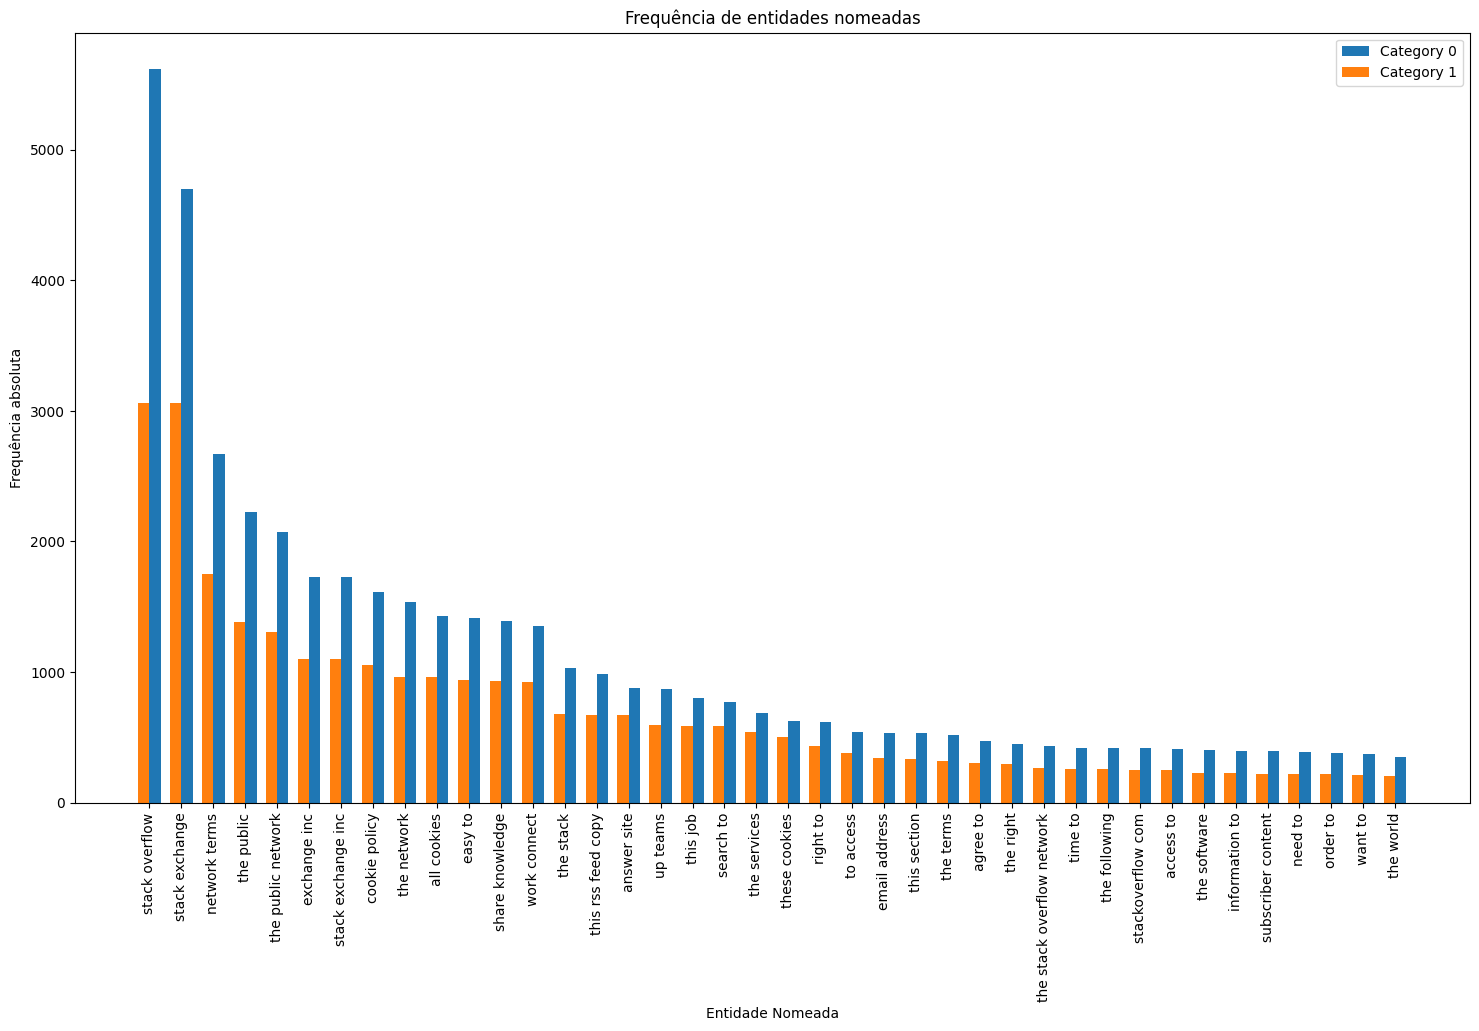

In [8]:
W = 0.35
plt.figure(figsize=(18,10))
plt.bar(np.array(range(len(y_0)))+W/2, (y_0), width=W, label='Category 0')
plt.bar(np.array(range(len(y_1)))-W/2, (y_1), width=W, label='Category 1')
plt.xticks(range(len(y_0)), x_0, rotation=90)
plt.ylabel("Frequência absoluta")
plt.xlabel("Entidade Nomeada")
plt.title("Frequência de entidades nomeadas")
plt.legend()
plt.show()

Pelo gráfico acima, parece que a categorização não foi muito bem sucedida, já que os dois grupos apresentam essencialmente a mesma distirbuição. Inspecionando os dados coletados, é possível perceber que na verdade existem muitas páginas inúteis, e que na realidade essa base não é muito boa. Só para validar os modelos e técnicas usadas, baixei um dataset simples de sentimento no twitter no Kaggle: https://www.kaggle.com/datasets/yasserh/twitter-tweets-sentiment-dataset

In [9]:
df_s = pd.read_csv('./Tweets.csv', index_col = 'textID').dropna(axis=0)
df_s

,text,selected_text,sentiment
textID,,,
cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
088c60f138,my boss is bullying me...,bullying me,negative
9642c003ef,what interview! leave me alone,leave me alone,negative
358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...
4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive


In [10]:
#Slight change to keep '****', since it is what replaces swearing, which might be interesting to keep
def prepro(word: str) -> str:
    try:
        o = re.sub("[\s|\n|!|@|#|$|%|`]+", " ", word)
        o = re.sub("[(|)|,|.| |-|\t|-]+", " ", o)
        o = ' '.join([i.lower() for i in o.split(' ') if not i.isdigit()])
        return o
    except TypeError:
        print("TYPE ERROR ON INPUT: ", word)

df_s['text_pro'] = df_s['text'].apply(prepro)
df_s

,text,selected_text,sentiment,text_pro
textID,,,,
cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,i d have responded if i were going
549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad i will miss you here in san diego
088c60f138,my boss is bullying me...,bullying me,negative,my boss is bullying me
9642c003ef,what interview! leave me alone,leave me alone,negative,what interview leave me alone
358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,sons of **** why couldn t they put them on th...
...,...,...,...,...
4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,wish we could come see u on denver husband lo...
4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,i ve wondered about rake to the client has ma...
f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,yay good for both of you enjoy the break you ...


In [11]:
# Put in function to facilitate
def extract_named_entities(X_0):
    pos_in_0 = " ".join(X_0)
    pos_output_0 = pos_tag(pos_in_0.split(' '), lang="eng", tagset="universal")
    #pos_output_0[:100]
    tag_pattern ="ENTIDADE: {<DET|PRT>?<NOUN>+<PRT>?<NOUN>*}"
    parser = nltk.RegexpParser(tag_pattern)
    named_entities_0 = []
    for p in parser.parse(pos_output_0):
        try:
            if (p.label()=="ENTIDADE"):
                named_entities_0.append(' '.join([i[0] for i in p.leaves()]))
        except AttributeError:
            continue

    vec_0 = CountVectorizer(vocabulary=set(named_entities_0),ngram_range=(2,4))
    X_0 = vec_0.fit_transform([pos_in_0])
    total_freq = X_0.sum(axis=0)
    wf_0 = {}
    for k, v in vec_0.vocabulary_.items():
        wf_0[k] = total_freq[0,v]

    wf_0 = {k: v for k, v in sorted(wf_0.items(), key=lambda item: item[1], reverse = True)}
    words_0 = list(wf_0.keys())
    x_0 = []
    y_0 = []

    for i in range(40):
        # print(f"Palavra: '{words_0[i]}'\t\tContagem: {wf_0[words_0[i]]}")
        x_0.append(words_0[i])
        y_0.append(wf_0[words_0[i]])
    return x_0, y_0

In [12]:
x_pos, y_pos = extract_named_entities(list(df_s[df_s['sentiment'] == 'positive']['text_pro']))
x_neut, y_neut = extract_named_entities(list(df_s[df_s['sentiment'] == 'neutral']['text_pro']))
x_neg, y_neg = extract_named_entities(list(df_s[df_s['sentiment'] == 'negative']['text_pro']))

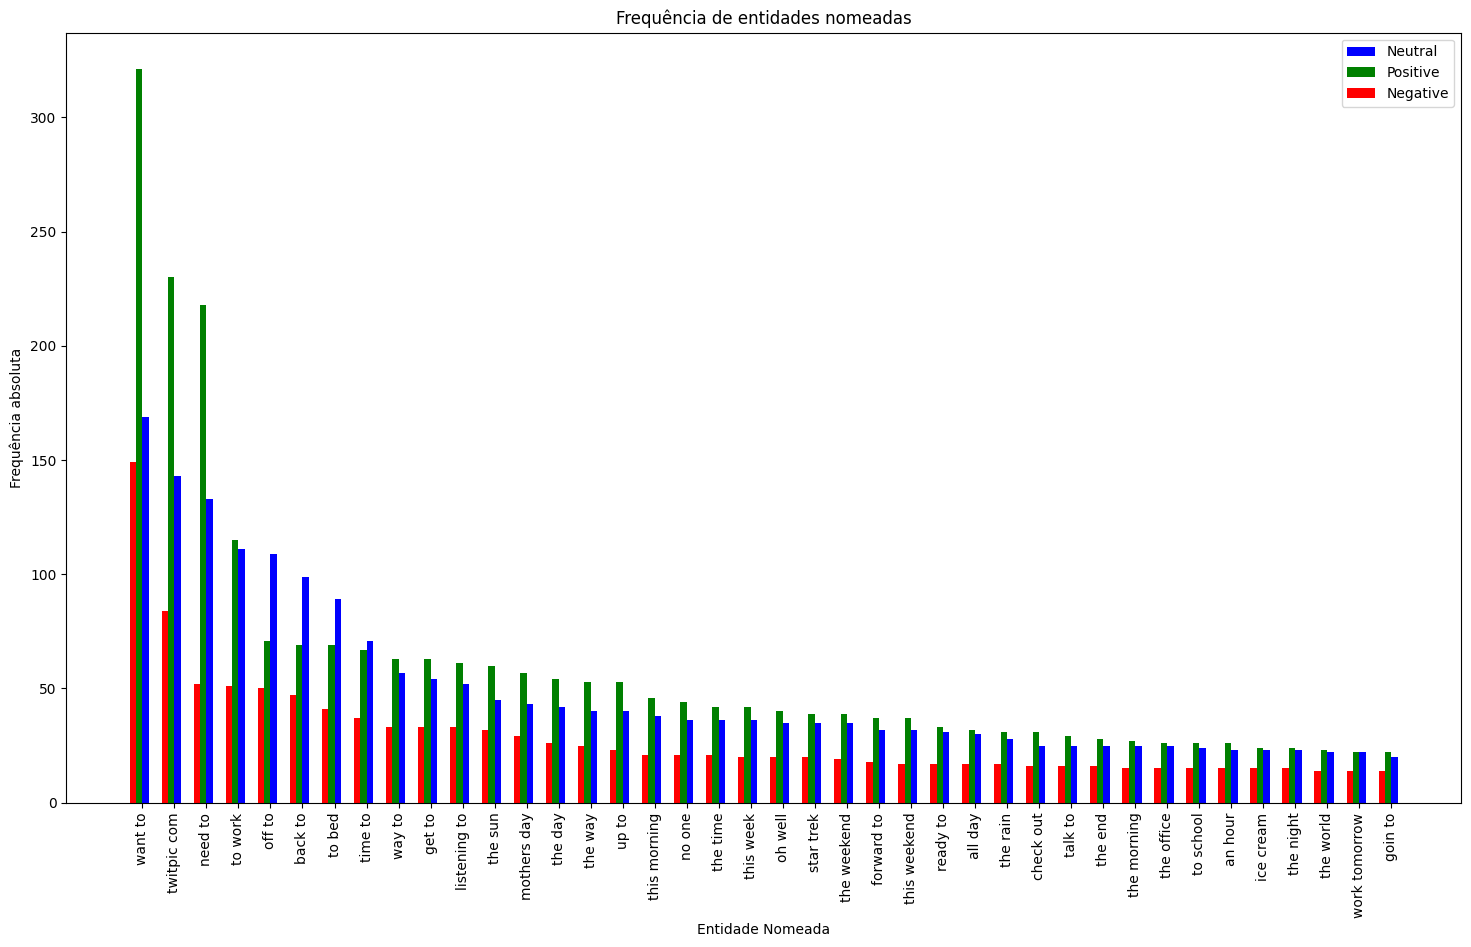

In [13]:
W = 0.2
plt.figure(figsize=(18,10))
plt.bar(np.array(range(len(y_neut)))+W/2, (y_neut), width=W, label='Neutral', color='b')
plt.bar(np.array(range(len(y_pos)))-W/2, (y_pos), width=W, label='Positive', color='g')
plt.bar(np.array(range(len(y_neg)))-3*W/2, (y_neg), width=W, label='Negative', color='r')
plt.xticks(range(len(y_neut)), x_neut, rotation=90)
plt.ylabel("Frequência absoluta")
plt.xlabel("Entidade Nomeada")
plt.title("Frequência de entidades nomeadas")
plt.legend()
plt.show()

De forma geral, esse dataset apresenta características semelhantes em termos de distribuição. Me parece que as entidades nomeadas não ficaram muito boas nesse contexto. Não parece ter nada muito bem definido. Existem coisas como star trek, que é uma entidade, mas também coisas como 'to bed' que não são.

# APS 5 
Continuando a atividade anterior, seria interessante criar um modelo de geração de textos, a partir das bases. Esse modelo pode ser treinado a partir dos dados acima, usando as entidades nomeadas como entrada, e os textos de onde foram extraídas como saída. Outra entrada é o sentimento do texto.

In [14]:
# Put in function to facilitate
def extract_named_entities_by_text(X, sentiments):
    named_entities_0 = []
    for s in sentiments:
        X_0 = list(X[X['sentiment'] == s]['text_pro'])
        for t in X_0:
            pos_output_0 = pos_tag(t.split(' '), lang="eng", tagset="universal")
            #pos_output_0[:100]
            tag_pattern ="ENTIDADE: {<DET|PRT>?<NOUN>+<PRT>?<NOUN>*}"
            parser = nltk.RegexpParser(tag_pattern)
            for p in parser.parse(pos_output_0):
                try:
                    if (p.label()=="ENTIDADE"):
                        named_entities_0.append([' '.join([i[0] for i in p.leaves()]), t, s])
                except AttributeError:
                    continue
    return np.array(named_entities_0)

Por conta de limitações de tamanho para o One Hot Encoding das sequências, precisei reduzir drasticamente o dataset.

In [15]:
size = 900
df_s_trunc = pd.concat([df_s[df_s['sentiment'] == 'negative'].sample(size//3), df_s[df_s['sentiment'] == 'neutral'].sample(size//3), df_s[df_s['sentiment'] == 'positive'].sample(size//3)])

Abaixo, coletamos as entidades e sentimentos (X) e os documentos de onde vieram (Y)

In [16]:
data = extract_named_entities_by_text(df_s_trunc, ['positive', 'negative', 'neutral'])
print(data[:3,:])

[['claire' 'claire love the show got into the office 5am and no radio'
  'positive']
 ['the show' 'claire love the show got into the office 5am and no radio'
  'positive']
 ['the office'
  'claire love the show got into the office 5am and no radio' 'positive']]


Tratamento dos dados, com OHE e Tokenizer

In [47]:
tokens_entities = Tokenizer(num_words=128)
tokenizer = Tokenizer(num_words=128)
def assemble_xy(data):
    tw = pd.DataFrame(data=data, columns=['entity', 'text', 'sentiment'])
    tw.loc[tw['sentiment'] == 'positive', 'sentiment'] = 1
    tw.loc[tw['sentiment'] == 'negative', 'sentiment'] = -1
    tw.loc[tw['sentiment'] == 'neutral', 'sentiment'] = 0
    tokenizer.fit_on_texts(tw['text'])
    padded_seq = pad_sequences(tokenizer.texts_to_sequences(tw['text']), maxlen=128)
    # print(f"Sequence example: ...{padded_seq[0][-15:-1]}")
    tokens_entities.fit_on_texts(tw['entity'])
    X = pad_sequences(tokens_entities.texts_to_sequences(tw['entity']), maxlen=127)
    X = np.concatenate([X,np.array(tw[['sentiment']])], axis = 1)
    y_ = np.array(padded_seq)
    y_ = y_.reshape(y_.shape[0]*y_.shape[1],1)
    onehot_encoder = OneHotEncoder(sparse=False)
    y = onehot_encoder.fit_transform(y_)
    y = y.reshape(padded_seq.shape[0], 128, X.shape[1])
    print(f'{X.shape=} {y.shape=}')
    return X.astype(int), y.astype(int)

In [48]:
X, Y = assemble_xy(data)

X.shape=(2894, 128) y.shape=(2894, 128, 128)


Modelo já treinado (levou uns 40min), e salvo e arquivo. Somente leitura abaixo.

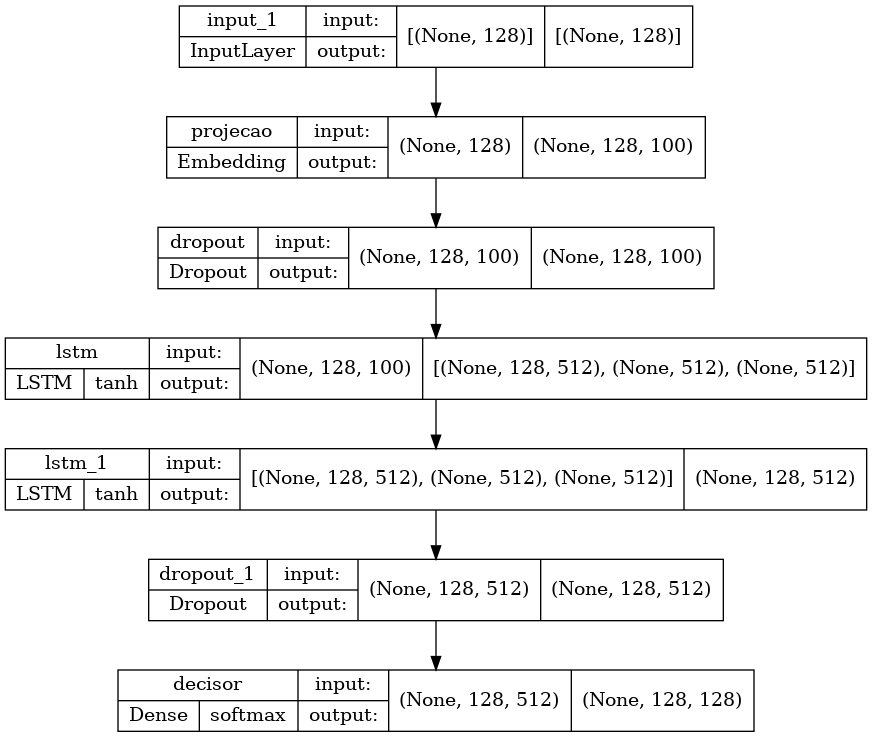

In [26]:
try:
    rede_neutal = load_model('rede')
except Exception:
    def rede_neural_geracao(input_dims, dim_out):
        input_layer = Input(shape=(input_dims,))
        x = input_layer
        x = Embedding(100, 100, name='projecao')(x)
        x = Dropout(0.1)(x)
        x, state_h, state_c = LSTM(512, return_sequences=True, return_state=True)(x)

        x = LSTM(512, return_sequences=True) (x, initial_state=[state_h, state_c])
        x = Dropout(0.1)(x)
        y = Dense(dim_out, activation='softmax', name='decisor')(x)
        return Model(input_layer, y)
    rede_neural = rede_neural_geracao(X.shape[1], Y.shape[1])
    rede_neural.compile(optimizer='adam', loss='categorical_crossentropy')
    rede_neural.fit(X, Y, epochs=500)
    rede_neural.save('./rede')
plot_model(rede_neural, show_shapes=True, show_layer_activations=True)

Depois de treinar o modelo, fiz uma função que recebe uma entidade nomeada e um sentimento, e produz um novo documento.

In [69]:
def make_pred(entity: str, sentiment: int):
    # print(f'{entity=}, {sentiment=}')
    X = pad_sequences(tokens_entities.texts_to_sequences([entity]), maxlen=127)
    X = np.concatenate([X,np.array([[sentiment]])], axis = 1)
    # print(X)
    pred = rede_neural.predict(X)
    return tokenizer.sequences_to_texts(np.argmax(pred, axis=1))

# -1 = negative
#  0 = neutral
#  1 = positive
import json
known_entities = list(json.loads(tokens_entities.get_config()['index_word']).values())
print(f"Top 10 entities: {known_entities[:10]}")
make_pred("home", -1)

Top 10 entities: ['i', 'the', 'a', 'to', 'day', 't', 'today', 'http', 'this', 'lol']


['i need soon bad need why bad bad need ve need man people come or soon or his though bad cool come need people bad though his come twitter bad need twitter hate or though hate bad his come bad ve sorry never cool why man man twitter bad man though need sorry right sorry bad his cool twitter soon right his cool though people right man soon or need see though need why come his though need come his would come ve right why his or twitter need his bad bad his bad bad way twitter need bad or need or right his right need come right soon his need soon sorry though right bad cool though bad come sorry why bad ve though need cool need']

In [70]:
make_pred("home", 0)

['i man cool cool bad bad though bad hate come man cool sorry come come man bad his cool sorry man cool need cool twitter bad hate bad why sorry come why his ve sorry his soon twitter bad bad right why sorry soon man why sorry bad though people people hate or bad why ve soon ve people right bad though cool ve man ve bad why cool his soon its come soon though way sorry never come bad need come bad ve man though right bad though why ll bad or way his why why why why his need would his or come bad hate hate need why bad need twitter come right bad man though bad soon man bad why ve bad come cool his']

In [72]:
make_pred("home", 1)

['the cool right why cool or man though his cool why his twitter sorry need why come sorry cool bad way right people soon sorry though need ve why though though come cool man man people cool man ve way come man right come need soon would why people people people though hate hate his man though hate would his soon soon come ve hate hate ve need hate come see sorry come why need man why sorry would though though why ve come come why way hate bad never its twitter why twitter why bad come come people would hate though why need man come twitter come come come though why bad why cool right why ve why come bad though come would hate his ve sorry']

Como podemos observar, a rede tenta se ajustar ao sentimento, porém apresenta muita dificuldade em formas sentenças coerentes. Por exemplo, quando o sentimento é positivo, é possível observar que a palavra cool, right e sorry aparecem com muita frequência, porêm para a mesma entidade nomeada, com sentimento negativo, bad, soon e need aparecem com mais frequência.